In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 
import datasets
from datasets import load_dataset
import tensorflow as tf
import tensorflow_hub as hub
from collections import defaultdict

In [3]:
msmarco_dataset = load_dataset("Tevatron/msmarco-passage")

Generating train split:   0%|          | 0/400782 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/6980 [00:00<?, ? examples/s]

Generating dl19 split:   0%|          | 0/43 [00:00<?, ? examples/s]

Generating dl20 split:   0%|          | 0/54 [00:00<?, ? examples/s]

Готовим датасет, выбираем из него небольшой сэмпл

In [4]:
rows = []
i = -1
j = -1
for row in msmarco_dataset['train']:
    i += 1
    qid = i
    query = row['query']
    for pos_ex in row['positive_passages']:
        j += 1
        docid = j
        title = pos_ex['title']
        text = pos_ex['text']
        mark = 1
        rows.append([qid, query, docid, title, text, mark])
    for neg_ex in row['negative_passages']:
        j += 1
        docid = j
        title = neg_ex['title']
        text = neg_ex['text']
        mark = 0
        rows.append([qid, query, docid, title, text, mark])
df = pd.DataFrame(rows, columns=['qid', 'query', 'docid', 'title', 'text', 'mark'])
df.to_csv('train_passages.csv', index=False)

In [3]:
df = pd.read_csv("train_passages.csv")
df = df[:62000]
df.to_csv('sample_passages.csv', index=False)

In [3]:
df = pd.read_csv("sample_passages.csv")

In [4]:
df

,qid,query,docid,title,text,mark
0,0,where is whitemarsh island,0,"Whitemarsh Island, Georgia","Whitemarsh Island, Georgia. Whitemarsh Island ...",1
1,0,where is whitemarsh island,1,What military strategy was used in the pacific?,the strategy of island hopping was used by the...,0
2,0,where is whitemarsh island,2,Whakaari / White Island,"For the island near Dunedin, see White Island,...",0
3,0,where is whitemarsh island,3,Jekyll Island,"Jekyll Island, at 5,700 acres, is the smallest...",0
4,0,where is whitemarsh island,4,Sibu Island,Sibu Island. A scuba diver at Sibu Island. Sib...,0
...,...,...,...,...,...,...
61995,2015,where does the word sociology derived,61995,Iron: historical information,Origin of name: from the Anglo-Saxon word iro...,0
61996,2015,where does the word sociology derived,61996,Occult,The occult world is more detailed than what ma...,0
61997,2015,where does the word sociology derived,61997,-,social. adj. 1. (Sociology) living or preferri...,0
61998,2016,where in italy is marble mined,61998,Carrara marble,Carrara marble (sometimes mistakenly Carrera m...,1


In [5]:
tmp = [(x, y, z) for x, y, z in zip(df['qid'], df['docid'], df['mark'])]
marks_dct = defaultdict(lambda: 0)
for elem in tmp:
    marks_dct[(elem[0], elem[1])] = elem[2]
tmp = [(x, y) for x, y in zip(df['qid'], df['query'])]
qid_dct = dict()
for elem in tmp:
    qid_dct[elem[0]] = elem[1]
tmp = [(x, y) for x, y in zip(df['docid'], df['text'])]
docid_dct = dict()
for elem in tmp:
    docid_dct[elem[0]] = elem[1]

Генерим эмбеддинги запросов и документов с помощью universal-sentence-encoder

In [6]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [8]:
text_mat = []
for txt in tqdm(df['text'].values):
    emb = embed([txt])
    text_mat.append(emb[0].numpy().tolist())
text_mat = np.array(text_mat)
with open('text_embs.npy', 'wb') as f:
    np.save(f, text_mat)

100%|██████████| 62000/62000 [02:54<00:00, 356.14it/s]


In [9]:
query_mat = []
for txt in tqdm(df['query'].unique()):
    emb = embed([txt])
    query_mat.append(emb[0].numpy().tolist())
query_mat = np.array(query_mat)
with open('query_embs.npy', 'wb') as f:
    np.save(f, query_mat)

100%|██████████| 2017/2017 [00:05<00:00, 368.64it/s]


# Annoy Index

In [10]:
from annoy import AnnoyIndex

Подгружаем матрицы эмбеддингов и запросов

In [7]:
with open('text_embs.npy', 'rb') as f:
    text_mat = np.load(f)
with open('query_embs.npy', 'rb') as f:
    query_mat = np.load(f)

Строим annoy-index

In [12]:
index = AnnoyIndex(f=512, metric='euclidean')
for i, vec in enumerate(text_mat):
    index.add_item(i, vec)

index.build(n_trees=500)
index.save('sample500.ann')

True

Можем подгрузить сохраненный индекс

In [13]:
index = AnnoyIndex(f=512, metric='euclidean')
index.load('sample500.ann')

True

Можем посмотреть число векторов в индексе

In [14]:
index.get_n_items()

62000

И число деревьев тоже

In [15]:
index.get_n_trees()

500

Можем извлечь вектор из индекса по его id-шнику

In [16]:
print(np.array(index.get_item_vector(0)))

[-0.00297327  0.0545827  -0.05818895 -0.01492311  0.01144736  0.0019332
 -0.00420693  0.00692477  0.05769333 -0.04039248  0.03380095  0.0400895
  0.04650482  0.01297525 -0.06679863  0.03822379  0.02235539 -0.05634981
 -0.06879866 -0.02300976  0.02059659  0.02564199  0.04864797 -0.03183704
 -0.04407287  0.06361139  0.00856677 -0.01863407 -0.02258668 -0.01980644
  0.0365736  -0.03256752  0.04562656 -0.04256786 -0.02479954  0.06052412
  0.02535084  0.0643217   0.03513807  0.01715632 -0.06640255  0.06147098
  0.06270671  0.03005228 -0.06418815 -0.00060343 -0.01845443 -0.05733818
 -0.05583275 -0.06011843 -0.03889617 -0.05329921 -0.06104665 -0.05905021
  0.00549478 -0.00646507 -0.06712613 -0.06074841  0.06571183 -0.01807469
 -0.05440898 -0.03270794  0.06587218  0.01605206  0.00452937 -0.05750464
  0.04454014  0.02807301  0.01064477 -0.06699127 -0.04881263  0.03539284
  0.07076441  0.05984703 -0.06951405  0.06280245 -0.0161358  -0.01943418
  0.00852432 -0.03037275  0.00745942  0.03254579  0.0

Также можем найти расстояние между векторами

In [17]:
index.get_distance(0, 1)

1.2352428436279297

Можем найти n-ближайших векторов к данному в индексе

In [18]:
index.get_nns_by_item(i=0, n=10, search_k=-1, include_distances=True)

([0, 36927, 37515, 36675, 37698, 57300, 6733, 26953, 37555, 36956],
 [0.0,
  0.7579076290130615,
  0.7839915156364441,
  0.7962557077407837,
  0.7968125939369202,
  0.8029389977455139,
  0.8083174824714661,
  0.8083174824714661,
  0.8090928196907043,
  0.8146184086799622])

In [19]:
items = index.get_nns_by_item(i=0, n=10, search_k=-1, include_distances=True)
for item in items[0]:
    print(str(item)+"\t"+docid_dct[item]+"\n")

0	Whitemarsh Island, Georgia. Whitemarsh Island (pronounced WIT-marsh) is a census-designated place (CDP) in Chatham County, Georgia, United States. The population was 6,792 at the 2010 census. It is part of the Savannah Metropolitan Statistical Area. The communities of Whitemarsh Island are a relatively affluent suburb of Savannah.

36927	Dougherty County, Georgia. Dougherty County is a county located in the southwestern portion of the U.S. state of Georgia. As of the 2010 census, the population was 94,565. The county seat and sole incorporated city is Albany. Dougherty County is included in the Albany, GA Metropolitan Statistical Area.

37515	Not to be confused with Lumberton, Texas. Lumberton is a city in Robeson County, North Carolina, United States. The population has grown to 21,542 in the 2010 census from 20,795 in the 2000 census. It is the county seat of Robeson County. Lumberton, located in southern North Carolina's Inner Banks region, is located on the Lumber River.

36675	C

А можем - к вектору запроса:

In [20]:
index.get_nns_by_vector(vector=query_mat[0], n=10, search_k=-1, include_distances=True)

([53524, 26, 53503, 53510, 5, 680, 13, 30769, 30781, 49504],
 [0.9458349347114563,
  1.0070568323135376,
  1.0070568323135376,
  1.054497480392456,
  1.0608590841293335,
  1.0613923072814941,
  1.0641976594924927,
  1.0731779336929321,
  1.0760210752487183,
  1.0892466306686401])

In [21]:
print(qid_dct[0]+"\n")
items = index.get_nns_by_vector(vector=query_mat[0], n=10, search_k=-1, include_distances=True)
for item in items[0]:
    print(str(item)+"\t"+docid_dct[item]+"\n")

where is whitemarsh island

53524	Guemes Island, located north of Anacortes, is a small island accessible by the Guemes Island Ferry. Find where to stay and what to do by reading this page. Guemes Island. Guemes Island - Facebook.

26	However, it has only 13% of HawaiÊ»iâs people. The island of HawaiÊ»i is the third largest island in Polynesia, behind the two main islands of New Zealand. The island is often referred to as the Island of HawaiÊ»i, the Big Island, or HawaiÊ»i Island to distinguish it from the state. Administratively, the whole island is encompassed by HawaiÊ»i County. As of the 2010 Census the population was 185,079. The county seat and largest city is Hilo.

53503	However, it has only 13% of HawaiÊ»iâs people. The island of HawaiÊ»i is the third largest island in Polynesia, behind the two main islands of New Zealand. The island is often referred to as the Island of HawaiÊ»i, the Big Island, or HawaiÊ»i Island to distinguish it from the state. Administratively, the wh

Оценим качество и перф нашего индекса (замерим, сколько правильных ответов попадут в топ-1)

In [22]:
%%time
def eval_qual(param=-1):
    good = 0
    for i, qvec in enumerate(query_mat):
        docid = index.get_nns_by_vector(vector=qvec, n=1, search_k=param, include_distances=False)
        if marks_dct[(i, docid[0])] == 1:
            good += 1
    print(f"{good/query_mat.shape[0]*100:.3f} %")
eval_qual(param=-1)

22.905 %
CPU times: user 892 ms, sys: 16.6 ms, total: 909 ms
Wall time: 908 ms


А если раскрутить search_k (число просматриваемых вершин, по дефолту равно n*n_trees)?

In [23]:
%%time
eval_qual(500)

22.905 %
CPU times: user 920 ms, sys: 678 µs, total: 921 ms
Wall time: 918 ms


In [24]:
%%time
eval_qual(1000)

24.046 %
CPU times: user 1.15 s, sys: 1.16 ms, total: 1.16 s
Wall time: 1.15 s


In [25]:
%%time
eval_qual(1500)

24.988 %
CPU times: user 1.51 s, sys: 1.36 ms, total: 1.51 s
Wall time: 1.51 s


In [26]:
%%time
eval_qual(2000)

25.285 %
CPU times: user 1.65 s, sys: 1.38 ms, total: 1.65 s
Wall time: 1.65 s


А если сварить индекс с большим числом деревьев?

In [27]:
index = AnnoyIndex(f=512, metric='euclidean')
for i, vec in enumerate(text_mat):
    index.add_item(i, vec)

index.build(n_trees=2000)
index.save('sample2000.ann')

True

In [28]:
%%time
eval_qual(500)

23.550 %
CPU times: user 2.63 s, sys: 95.9 ms, total: 2.72 s
Wall time: 2.79 s


In [29]:
%%time
eval_qual(1000)

24.938 %
CPU times: user 3.12 s, sys: 426 µs, total: 3.12 s
Wall time: 3.11 s


In [30]:
%%time
eval_qual(1500)

25.285 %
CPU times: user 3.39 s, sys: 4.79 ms, total: 3.39 s
Wall time: 3.39 s


In [31]:
%%time
eval_qual(2000)

25.830 %
CPU times: user 3.53 s, sys: 4.58 ms, total: 3.54 s
Wall time: 3.54 s


Таким образом, через питонячий апи можем крутить два основных параметра, аффектящих производительность - число деревьев и search_k

# Faiss Index

In [8]:
import faiss

Создаем плоский индекс (считаются расстояния от вектора запроса до всех векторов, обучать ненужно)

In [9]:
emb_size = 512
index = faiss.IndexFlatL2(emb_size)

In [10]:
print(f" Пока индекс пустой {index.ntotal}")
index.add(text_mat)
print(f" После добавления векторов: {index.ntotal}")

 Пока индекс пустой 0
 После добавления векторов: 62000


Найдем 10 ближайших документов для 0-го запроса:

In [11]:
#Важно конвертировать в np.float32
query_mat = query_mat.astype(np.float32)
D, I = index.search(query_mat[:1], 10)

In [12]:
#Расстояния до найденных документов
D

array([[0.89460367, 1.0141635 , 1.0141635 , 1.103269  , 1.103269  ,
        1.111965  , 1.125422  , 1.1265535 , 1.1325166 , 1.1517109 ]],
      dtype=float32)

In [13]:
#Индексы документов
I

array([[53524,    26, 53503, 37493, 49500, 53510,     5,   680,    13,
        30769]])

In [14]:
print(qid_dct[0]+"\n")
for idx in I[0]:
    print(str(idx)+"\t"+docid_dct[idx]+"\n")

where is whitemarsh island

53524	Guemes Island, located north of Anacortes, is a small island accessible by the Guemes Island Ferry. Find where to stay and what to do by reading this page. Guemes Island. Guemes Island - Facebook.

26	However, it has only 13% of HawaiÊ»iâs people. The island of HawaiÊ»i is the third largest island in Polynesia, behind the two main islands of New Zealand. The island is often referred to as the Island of HawaiÊ»i, the Big Island, or HawaiÊ»i Island to distinguish it from the state. Administratively, the whole island is encompassed by HawaiÊ»i County. As of the 2010 Census the population was 185,079. The county seat and largest city is Hilo.

53503	However, it has only 13% of HawaiÊ»iâs people. The island of HawaiÊ»i is the third largest island in Polynesia, behind the two main islands of New Zealand. The island is often referred to as the Island of HawaiÊ»i, the Big Island, or HawaiÊ»i Island to distinguish it from the state. Administratively, the wh

А теперь оценим качество и перф:

In [15]:
def eval_qual_faiss(loc_index):
    good = 0
    D, I = loc_index.search(query_mat, 1)
    for i, docid in enumerate(I):
        if marks_dct[(i, docid[0])] == 1:
            good += 1
    print(f"{good/query_mat.shape[0]*100:.3f} %")

In [17]:
def eval_qual_faiss_bs1(loc_index):
    good = 0
    for i, q in enumerate(query_mat):
        D, I = loc_index.search(np.array([q]).astype(np.float32), 1)
        if marks_dct[(i, I[0][0])] == 1:
            good += 1
    print(f"{good/query_mat.shape[0]*100:.3f} %")

In [16]:
%%time
eval_qual_faiss(index)

26.971 %
CPU times: user 10.7 s, sys: 0 ns, total: 10.7 s
Wall time: 2.52 s


In [18]:
%%time
eval_qual_faiss_bs1(index)

26.971 %
CPU times: user 27.9 s, sys: 0 ns, total: 27.9 s
Wall time: 27.9 s


Для целой матрицы все очень быстро и хорошо... Но на проде так не бывает

Индекс можно сохранять:

In [19]:
faiss.write_index(index, "flat.index")
index = faiss.read_index("flat.index")

# А какие еще типы индексов поддерживает faiss?

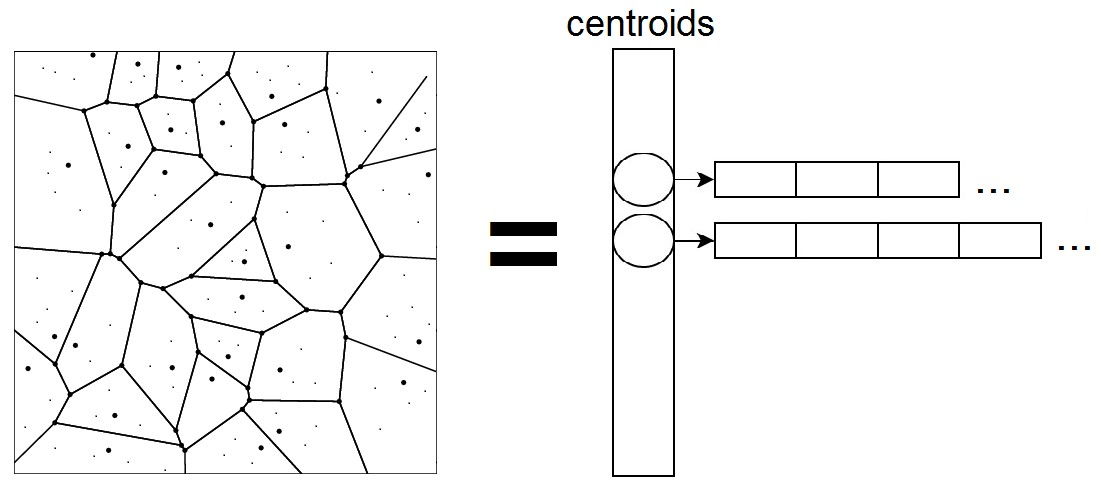

IVF-индекс:

In [20]:
num_centroids = 1000
quantiser = faiss.IndexFlatL2(emb_size) 
index = faiss.IndexIVFFlat(quantiser, emb_size, num_centroids)
print(f"Индекс обучен: {index.is_trained}")
print("Обучаем индекс...")
index.train(text_mat)
print(f"Индекс обучен: {index.is_trained}")
print(f"Размер индекса: {index.ntotal}")
print("Добавляем вектора...")
index.add(text_mat)
print(f"Размер индекса: {index.ntotal}")
faiss.write_index(index, "IVFflat.index")
index = faiss.read_index("IVFflat.index")

Индекс обучен: False
Обучаем индекс...
Индекс обучен: True
Размер индекса: 0
Добавляем вектора...
Размер индекса: 62000


Задаем число центроид, которое обходим при поиске:

In [21]:
%%time
index.nprobe = 1000
eval_qual_faiss_bs1(index)

26.971 %
CPU times: user 29.2 s, sys: 0 ns, total: 29.2 s
Wall time: 29.2 s


In [22]:
%%time
index.nprobe = 750
eval_qual_faiss_bs1(index)

26.971 %
CPU times: user 23.4 s, sys: 0 ns, total: 23.4 s
Wall time: 23.4 s


In [47]:
%%time
index.nprobe = 500
eval_qual_faiss_bs1(index)

26.971 %
CPU times: user 8.53 s, sys: 5.76 ms, total: 8.54 s
Wall time: 8.53 s


In [48]:
%%time
index.nprobe = 250
eval_qual_faiss_bs1(index)

26.971 %
CPU times: user 4.51 s, sys: 5 ms, total: 4.51 s
Wall time: 4.52 s


In [49]:
%%time
index.nprobe = 100
eval_qual_faiss_bs1(index)

26.872 %
CPU times: user 2.04 s, sys: 329 µs, total: 2.04 s
Wall time: 2.04 s


In [50]:
%%time
index.nprobe = 50
eval_qual_faiss_bs1(index)

26.673 %
CPU times: user 1.22 s, sys: 4.24 ms, total: 1.22 s
Wall time: 1.22 s


In [51]:
%%time
index.nprobe = 1
eval_qual_faiss_bs1(index)

17.799 %
CPU times: user 198 ms, sys: 83 µs, total: 198 ms
Wall time: 197 ms


Видно, что можем сильно разогнаться, и даже без потери качества (до какого-то уровня)

Попробуем поквантовать индексы (чтобы сэкономить память)

In [52]:
bits = 8
num_subq = 64
quantizer = faiss.IndexFlatL2(emb_size)
index = faiss.IndexIVFPQ(quantizer, emb_size, num_centroids, num_subq, bits) 
index.train(text_mat)
index.add(text_mat)
faiss.write_index(index, "IVF1000PQ64.index")

In [53]:
%%time
index.nprobe = 1000
eval_qual_faiss_bs1(index)

25.434 %
CPU times: user 19.4 s, sys: 3.71 ms, total: 19.4 s
Wall time: 19.5 s


Из-за сжатия качество упало даже на максимальном числе центроид (но не сильно)

In [54]:
%%time
index.nprobe = 100
eval_qual_faiss_bs1(index)

25.335 %
CPU times: user 2.32 s, sys: 471 µs, total: 2.32 s
Wall time: 2.32 s


In [55]:
%%time
index.nprobe = 1
eval_qual_faiss_bs1(index)

17.501 %
CPU times: user 265 ms, sys: 15 µs, total: 265 ms
Wall time: 263 ms


А еще можем создавать faiss-индексы через фабрики, а не через классы:

In [56]:
index = faiss.index_factory(512, "Flat", faiss.METRIC_L2)
index = faiss.index_factory(512, "IVF1000,Flat", faiss.METRIC_L2)
index = faiss.index_factory(512, "IVF1000,PQ64", faiss.METRIC_L2)

Подробный гайд по фабрикам: https://github.com/facebookresearch/faiss/wiki/The-index-factory

# hnswlib

Рассмотрим библиотеку, основанную на Hierarchical Navigable Small World

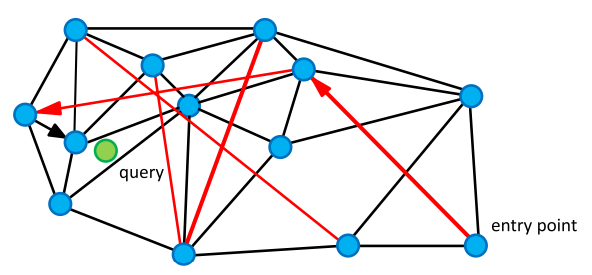

In [59]:
import hnswlib

Создаем индекс - задаем метрику и размер эмбеддинга

In [60]:
index = hnswlib.Index(space = 'l2', dim = 512)

Инициализируем индекс - нужно сразу задать число элементов

In [61]:
#M - число двойных связей для каждого нового элемента
#Размер динамического списка ближайших соседей - при конструировании
index.init_index(max_elements = 62000, ef_construction = 20, M = 24)

Добавляем эмбеддинги в индекс

In [62]:
index.add_items(text_mat)

ef - размер динамического списка ближайших соседей при поиске

In [63]:
index.set_ef(ef=50)

Индекс можно сохранить...

In [64]:
index.save_index("hnsw_efcons20_M24.bin")

И подгрузить, увеличив емкость:

In [65]:
index.load_index("hnsw_efcons20_M24.bin", max_elements = 70000)

Поищем документы в индексе:

In [66]:
#k - число документов, которое ищем 
I, D = index.knn_query(query_mat[:1], k = 10)
print(qid_dct[0]+"\n")
for idx in I[0]:
    print(str(idx)+"\t"+docid_dct[idx]+"\n")

where is whitemarsh island

53524	Guemes Island, located north of Anacortes, is a small island accessible by the Guemes Island Ferry. Find where to stay and what to do by reading this page. Guemes Island. Guemes Island - Facebook.

26	However, it has only 13% of HawaiÊ»iâs people. The island of HawaiÊ»i is the third largest island in Polynesia, behind the two main islands of New Zealand. The island is often referred to as the Island of HawaiÊ»i, the Big Island, or HawaiÊ»i Island to distinguish it from the state. Administratively, the whole island is encompassed by HawaiÊ»i County. As of the 2010 Census the population was 185,079. The county seat and largest city is Hilo.

53503	However, it has only 13% of HawaiÊ»iâs people. The island of HawaiÊ»i is the third largest island in Polynesia, behind the two main islands of New Zealand. The island is often referred to as the Island of HawaiÊ»i, the Big Island, or HawaiÊ»i Island to distinguish it from the state. Administratively, the wh

Оценим качество индекса в целом:

In [67]:
def eval_qual_hnsw_bs1(loc_index):
    good = 0
    for i, q in enumerate(query_mat):
        I, D = loc_index.knn_query(np.array([q]).astype(np.float32), k = 1)
        if marks_dct[(i, I[0][0])] == 1:
            good += 1
    print(f"{good/query_mat.shape[0]*100:.3f} %")

In [68]:
%%time
eval_qual_hnsw_bs1(index)

18.394 %
CPU times: user 122 ms, sys: 7.6 ms, total: 130 ms
Wall time: 129 ms


Качество невысокое, давайте потюним параметры (сначала ef):

In [69]:
%%time
index.set_ef(ef=75)
eval_qual_hnsw_bs1(index)

24.095 %
CPU times: user 398 ms, sys: 132 µs, total: 398 ms
Wall time: 397 ms


In [70]:
%%time
index.set_ef(ef=100)
eval_qual_hnsw_bs1(index)

24.789 %
CPU times: user 483 ms, sys: 4.03 ms, total: 487 ms
Wall time: 484 ms


In [71]:
%%time
index.set_ef(ef=150)
eval_qual_hnsw_bs1(index)

25.136 %
CPU times: user 650 ms, sys: 51 µs, total: 650 ms
Wall time: 648 ms


Поднимем M:

In [72]:
index = hnswlib.Index(space = 'l2', dim = 512)
index.init_index(max_elements = 62000, ef_construction = 20, M = 40)
index.add_items(text_mat)
index.set_ef(ef=150)

In [73]:
%%time
eval_qual_hnsw_bs1(index)

26.376 %
CPU times: user 889 ms, sys: 198 µs, total: 889 ms
Wall time: 885 ms


И ef_construction тоже:

In [74]:
index = hnswlib.Index(space = 'l2', dim = 512)
index.init_index(max_elements = 62000, ef_construction = 400, M = 40)
index.add_items(text_mat)
index.set_ef(ef=150)

In [75]:
%%time
eval_qual_hnsw_bs1(index)

26.872 %
CPU times: user 2.02 s, sys: 291 µs, total: 2.02 s
Wall time: 2.02 s


# Источники

1. https://habr.com/ru/companies/okkamgroup/articles/509204/ (FAISS: Быстрый поиск лиц и клонов на многомиллионных данных)
2. https://habr.com/ru/companies/vk/articles/338360/ (Методы приближенного поиска ближайших соседей)
3. https://github.com/facebookresearch/faiss/wiki/ (faiss-wiki)
4. https://github.com/spotify/annoy/tree/main (annoy гитхаб и вики)
5. https://github.com/nmslib/hnswlib (hnswlib вики)
6. https://neerc.ifmo.ru/wiki/index.php?title=Поиск_ближайших_соседей_с_помощью_иерархического_маленького_мира (об алгоритме hnswlib)